# SPRINT 3: GENERACIÓN DE MODELOS DE REGRESIÓN MÚLTIPLE
AUTOR: *Adrián Robles Arques*

En este último sprint de la asignatura de introducción a la Inteligencia artifical y el machine learning vamos a completar el proceso de generación de modelos de regresión múltiple.

Para los apartados de adquisición y análisis de datos voy a reutilizar el código visto previamente en los sprints 1 y 2, y emplearé mi analisis previo para elaborar las hipótesis de partida con las que generar los diferentes modelos requeridos.

# 1. ADQUISICIÓN DE DATOS

In [1]:
#importamos bibliotecas
import pandas as pd
from google.colab import files
import io

#Cargamos los datos desde local
uploaded = {}
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['insurance.csv']))

Saving insurance.csv to insurance.csv


#2. EXPLORACIÓN

In [4]:
#En este paso hacemos una primera revisión de los datos
#Vamos a hacer el código más compacto
functions = ['columns', 'dtypes', 'head()', 'tail()', 'sample(5)',
             'describe()', 'shape',
             'info()', 'isnull()', 'isnull().sum()']

for f in functions:
  print(f)
  print(eval('data.'+ f))
  print('----------------------------------')

columns
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')
----------------------------------
dtypes
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
----------------------------------
head()
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
----------------------------------
tail()
      age     sex    bmi  children smoker     region     charges
1333   50    male  30.97         3     no  northwest  10600.5483
1334   18  female  31.92         0     no  northeast   2205.9808
1335   18  female  36.85         0     no  so

### 2.1. EXPLORACIÓN ANALÍTICA

Tras analizar los datos del conjunto, vemos que tenemos 7 variables, de las cuales tomaremos "Charges" como nuestra variable dependiente, que será la que intentaremos analizar en función de las otras 6.

De las 6 variables restantes, tenemos 3 variables categóricas (Sex, Smoker y Region) y otras 3 variables numéricas (Age, Bmi y Children), siendo de estas últimas dos variables discretas y solo una continua.

Hemos verificado además que no existe ningún dato nulo en todo el conjunto de datos, por lo tanto podemos operar y trabajar con el mismo sin temer que la perdida de información afecte a nuestras conclusiones, aunque el tamaño y la representatividad de la muestra sí podría ser objeto de discusión.

Vemos que en nuestra variable dependiente existe una gran variabilidad, con un valor mínimo de 1121,87  y un máximo de 63770,43. Además, la media, que es de 13270,42, queda muy por debajo del máximo, incluso el percentil 75 es inferior a 20000, lo que parece indicar que los valores muy elevados podrían tratarse de un conjunto muy pequeño de datos, que incluso podrían ser anómalos.

Con el número de hijos ocurre algo similar, ya que vemos que tan solo un 25% del conjunto tiene 3 o más hijos, siendo 5 el valor máximo. Así como con el valor de IMC más del 75% tiene un valor por debajo de 35, siendo el máximo sin embargo 53,13. La variable edad, sin embargo, está distribuida de forma más homogénea.

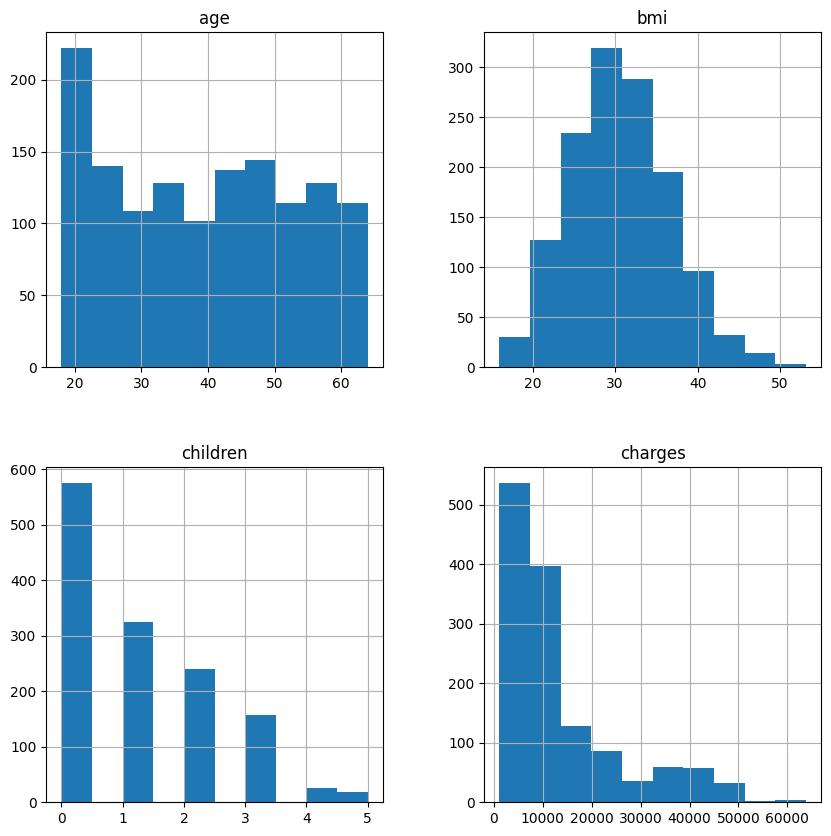

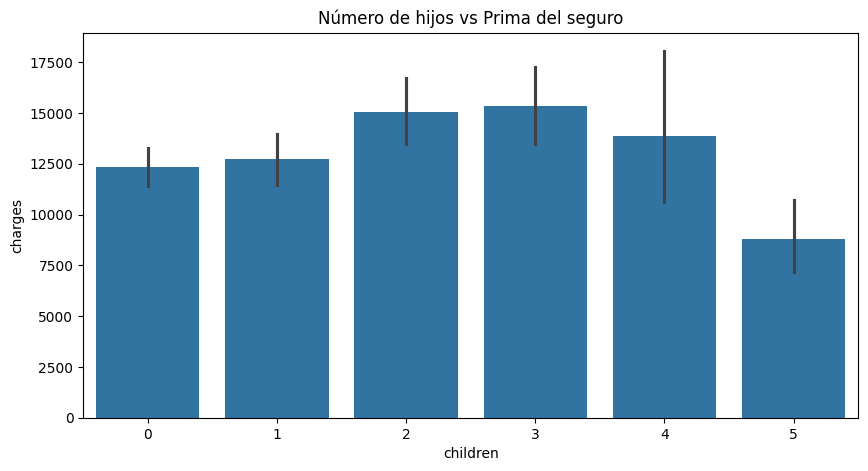

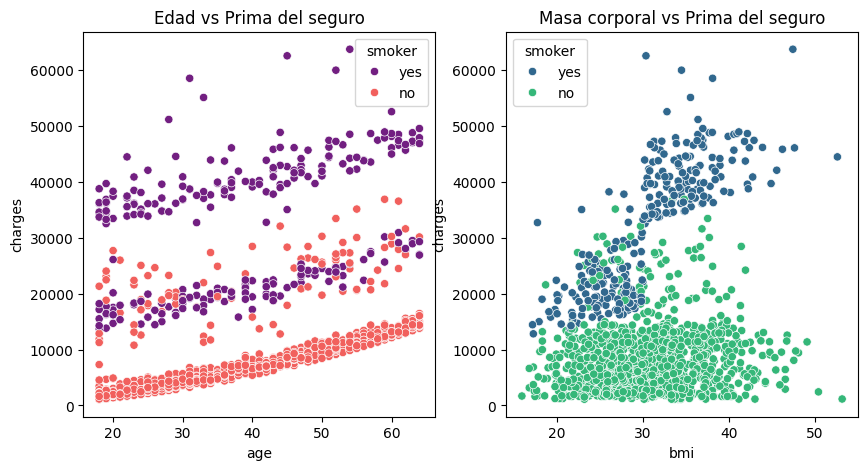

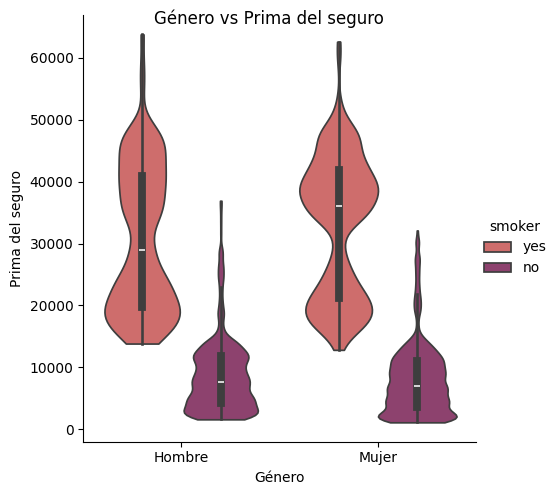

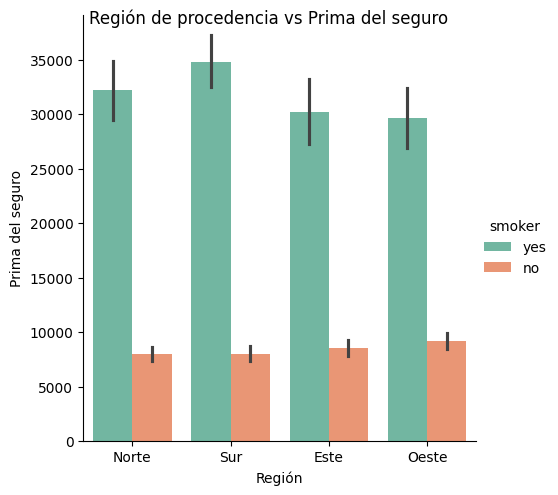

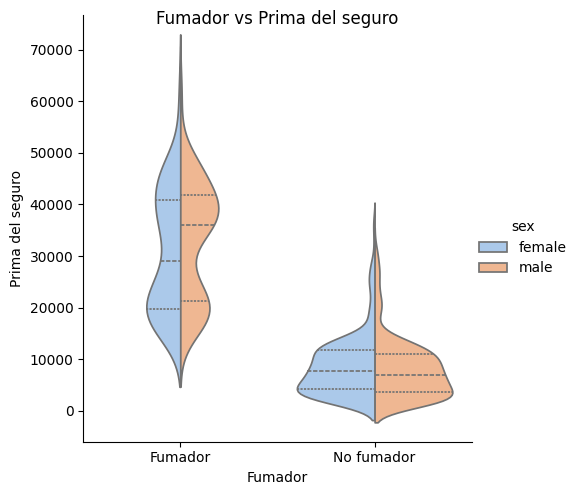

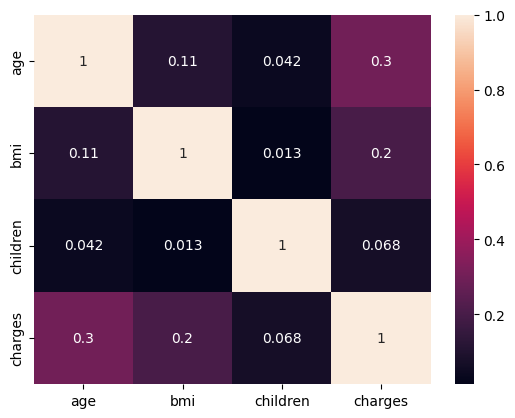

In [8]:
#Empezamos importando la librería matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Visualizamos histogramas de las variables numéricas
data.hist(figsize=(10,10))
plt.show()

#Vamos a analizar las relaciones entre variables
plt.figure(figsize=(10,5))
sns.barplot(x = data["children"], y= data["charges"])
plt.title('Número de hijos vs Prima del seguro')
plt.show()

plot = plt.figure(figsize=(10,5))

ax1 = plot.add_subplot(121)
sns.scatterplot(data = data, x = "age", y = "charges", hue = "smoker",
                palette = 'magma')
ax1.set_title('Edad vs Prima del seguro')

ax2 = plot.add_subplot(122)
sns.scatterplot(data = data, x = "bmi", y = "charges", hue = "smoker",
                palette = 'viridis')
ax2.set_title('Masa corporal vs Prima del seguro')

plt.show()

GVSP = sns.catplot(data = data, x="sex", y="charges", hue="smoker",
    kind="violin", bw_adjust=.5, cut=0, palette = 'flare' )
GVSP.set_xticklabels(["Hombre", "Mujer"])
GVSP.set_axis_labels("Género", "Prima del seguro")
plt.suptitle('Género vs Prima del seguro')
plt.show()

RVSP = sns.catplot(data = data, x = "region", y = "charges", hue = "smoker",
            palette = 'Set2', kind = 'bar')
RVSP.set_xticklabels(["Norte", "Sur", "Este", "Oeste"])
RVSP.set_axis_labels("Región", "Prima del seguro")
plt.suptitle('Región de procedencia vs Prima del seguro')
plt.show()

FVSP = sns.catplot(data = data, x = 'smoker', y = 'charges', hue = 'sex',
                   kind = 'violin', palette = 'pastel',
                   inner="quart", split=True)
FVSP.set_xticklabels(["Fumador", "No fumador"])
FVSP.set_axis_labels("Fumador", "Prima del seguro")
plt.suptitle('Fumador vs Prima del seguro')
plt.show()

### 2.2. ANALISIS VISUAL

En un análisis visual podemos corroborar las conclusiones que extrajimos sobre las variables numéricas y su comportamiento en el apartado anterior, como se referencia en sus respectivos histogramas.

Además, una vez comenzamos a comparar cada una de las variables independientes con nuestra variable objetivo, el coste de la prima del seguro, vemos que tanto la edad como el IMC parecen presentar un comportamiento lineal respecto al valor de la prima, con un sesgo añadido claramente marcado por el dato de ser o no fumador.

El sexo de la persona, relativamente a las otras tras, no parece ser tan relevante, aunque sí se aprecian diferencias menores en los percentiles que se establecen para mujeres y hombres, no parece que la representación general de los datos varíe en demasía.

El valor de la prima en función del número de hijos presenta casi una distribución normal, creciendo hasta alcanzar los 3 hijos y descendiendo posteriormente. Sin embargo, el valor no cambia mucho con respecto a la media, dado que se mueve entre 12500 y 15000, teniendo en cuenta la ancha franja de valores de prima que se presenta, y que la media de la misma es 13270,42, estos valores bien podrían explicarse como una pequeña variación en torno a la media sin mayor impacto.

Por último, la variable de región parece ser completamente irrelevante, las diferencias que se aprecian son mínimas y bien podrían deberse a cualquiera de las otras variables, por ende esta no parece tener ningún impacto en la prima del seguro, al menos en primera aproximación.

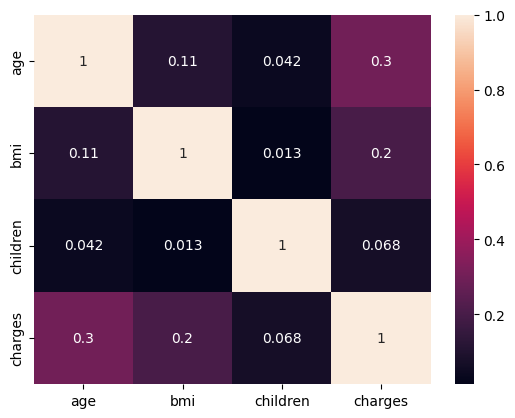

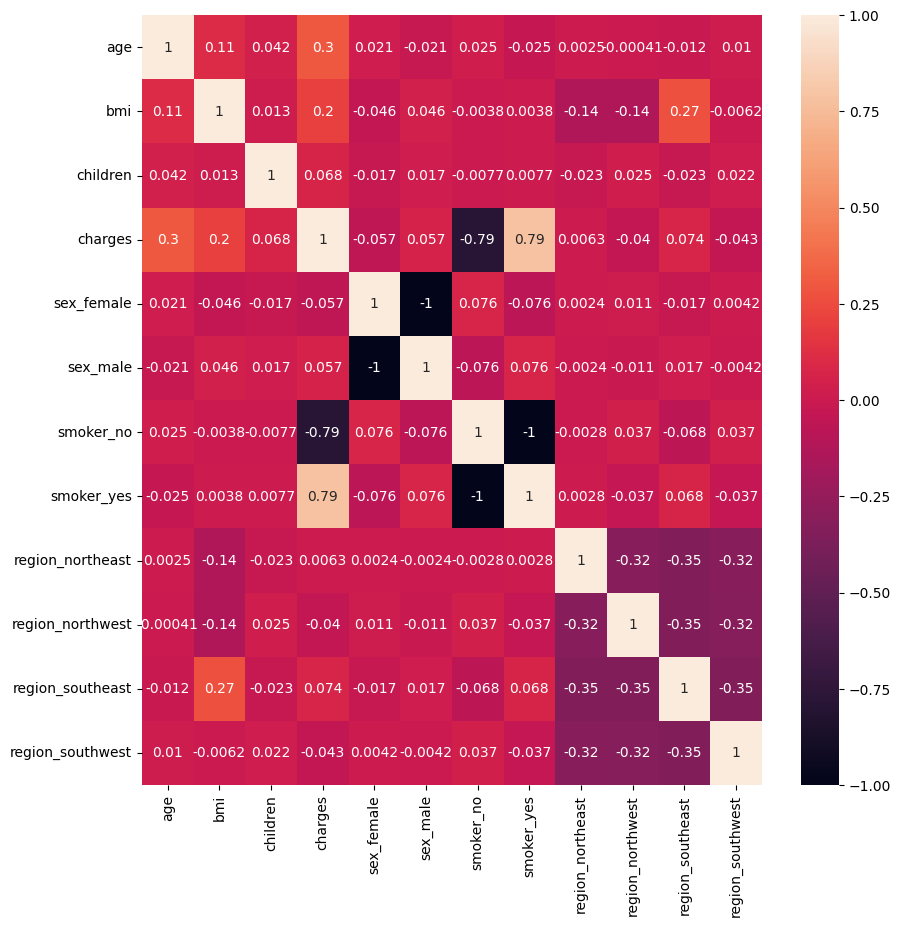

In [15]:
#Analizamos la correlación de variables solo numéricas
correl = data.corr(numeric_only= True)
sns.heatmap(correl, annot= True)
plt.show()

#También vamos a separar las variables categóricas y aplicar OHE
cat_colums = ['sex', 'smoker', 'region']
OHE_data = pd.get_dummies(data, columns = cat_colums,
                          prefix= ['sex', 'smoker', 'region'],
                          prefix_sep= '_', dtype= int)
plt.figure(figsize=(10,10))
correl_new = OHE_data.corr(numeric_only= True)
sns.heatmap(correl_new, annot= True)
plt.show()

## 2.3 ANÁLISIS DE CORRELACIÓN

El estudio de la correlación de variables confirma en gran medida las conclusiones extraidas en el análisis visual, especialmente tras la codificación de las columnas categóricas mediante el método "One hot".

Aquí podemos ver, eliminadas las correlaciones cruzadas dentro de las propias variables categóricas tras ser reclasificadas, que son mutuamente excluyentes y por ello aparecen con correlaciones negativas entre sí, que las variables independientes no presentan correlación entre sí. Las únicas destacables serían las de IMC con Southwest (0,27), donde es ligeramente más elevado que en las otras, lo que también explicaría el incremento reflejado en la prima que veíamos en las gráficas, y la del IMC con la edad (0,11) que es muy reducida y hasta esperable.

Finalmente vemos que las variables con mayor índice de correlación con nuestra variable objetivo son "Fumador", "Edad" e "IMC", con un valor de 0,79 (-0,79 la opción negativa), 0.3 y 0.2 respectivamente. Por tanto estas deberán ser el eje centras de nuestros modelos, pudiendo introducir las otras en mayor o menor medida para afinar las predicciones.

# 3. FASE DE ENTRENAMIENTO Y VALIDACIÓN

Partiendo de nuestro análisis previo, podemos establecer un conjunto de variables clave para el estudio de nuestra variable objetivo, que serán "Fumador", "Edad", e "IMC". Desde aquí trabajaremos con los datos ya realizada la codificación de las columnas categóricas de forma que sean interpretables para el modelado posterior.

Vamos a establecer, tal como se nos pide, un total de 4 hipótesis y comparar los resultados obtenidos a partir de las métricas. Hay que recalcar que un análisis gráfico de resultados es más complejo para un ajuste multilineal, ya que el conjunto es N-dimensional y lo ajustamos a un hiperlano de dimensión N-1, algo dificilmente visualizable para N>3, incluyendo en esta N tanto la variable dependiente como todas las dependientes.

In [18]:
#Importamos las bibliotecas y funciones necesarias
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## 3.1. HIPOTESIS 1: CONJUNTO DE MÍNIMA DIMENSIONALIDAD

Dado que hemos establecido que las variables independientes mínimas para estudiar nuestra variable dependiente según parece indicarnos el análisis de correlaciones son "Fumador", "Edad", e "IMC"; vamos a probar con una primera aproximación en la que realizaremos el ajuste empleando tan solo dichas variables.

In [33]:
#Creamos nuestro nuevo subconjunto de datos
core = OHE_data[['charges', 'smoker_yes','smoker_no' , 'age', 'bmi']]

#Hacemos una pequeña visualización
core.head()

,charges,smoker_yes,smoker_no,age,bmi
0,16884.92400,1,0,19,27.900
1,1725.55230,0,1,18,33.770
2,4449.46200,0,1,28,33.000
3,21984.47061,0,1,33,22.705
4,3866.85520,0,1,32,28.880


In [80]:
#Definimos las variables dependientes e independientes
X_core = core.drop('charges', axis = 1)
Y_core = core['charges']

#Establecemos los subconjuntos de entrenamiento y validación
X_core_train, X_core_test, Y_core_train, Y_core_test = train_test_split(
    X_core, Y_core, test_size= 0.2, random_state= 24)

In [83]:
#Estblecemos la regresión y entrenamos el modelo
Reg_core = LinearRegression()
Reg_core.fit(X_core_train, Y_core_train)

LinearRegression()

### 3.1.1 Entrenamiento del modelo
Hasta aquí hemos preparado los datos y entrenado el modelo, es el momento de validar y comprobar los resultados.

In [24]:
#Validación del modelo

#Predicción de Y para el modelo entrenado a partir de los datos test
Y_core_predict = Reg_core.predict(X_core_test)

#Calculamos los resultados de las métricas estadísticas
mse_core = mean_squared_error(Y_core_test, Y_core_predict)
mae_core = mean_absolute_error(Y_core_test, Y_core_predict)
r2_core = r2_score(Y_core_test, Y_core_predict)

print('MSE = {}'.format(mse_core))
print('MAE = {}'.format(mae_core))
print('R2 = {}'.format(r2_core))

MSE = 34982225.238598265
MAE = 4417.428587736348
R2 = 0.7701938269038249


In [87]:
core_media = Y_core.mean()
print('Media de la variable dependiente = {}'.format(core_media))
print('La relación entre el error medio sobre el valor medio es del {}%'.format(
    round(mae_core/core_media *100,2)))

Media de la variable dependiente = 13270.422265141257
La relación entre el error medio sobre el valor medio es del 33.29%


### 3.1.2. Validación del modelo
Vemos que el error medio cuadrático se dispara en esta predicción, pero teniendo en cuenta que el error medio absoluto es de 4417,42 es comprensible que al elevar al cuadrado este valor se dispare. Para un valor medio de de la variable de 13270,42, podemos ver que el MAE representa una variación del 33,29% de dicho valor, lo que es demasiado elevado.

Atendiendo al valor de R2, que es de 0,77, se puede intuir la relación lineal de la variable objetivo con las tres variables nucleo que hemos establecido pero es un valor de confianza demasiado bajo para contentarnos con este modelo.


## 3.2. HIPÓTESIS 2: NÚCLEO ENRIQUECIDO

Vistas las limitaciones de la hipótesis anterior, vamos a añadir alguna columna más que puedan considerarse relevantes, como la de hijos, que en este caso se tratará como una variable numérica discreta.

In [62]:
#Creamos nuestro segundo subconjunto de datos
core_ex = OHE_data[['charges', 'smoker_yes','smoker_no' , 'age', 'bmi','children']]

#Hacemos una pequeña visualización
core_ex.head()

,charges,smoker_yes,smoker_no,age,bmi,children,sex_male,sex_female
0,16884.92400,1,0,19,27.900,0,0,1
1,1725.55230,0,1,18,33.770,1,1,0
2,4449.46200,0,1,28,33.000,3,1,0
3,21984.47061,0,1,33,22.705,0,1,0
4,3866.85520,0,1,32,28.880,0,1,0


In [63]:
#Definimos las variables dependientes e independientes
X_core_ex = core_ex.drop('charges', axis = 1)
Y_core_ex = core_ex['charges']

#Establecemos los subconjuntos de entrenamiento y validación
X_core_ex_train, X_core_ex_test, Y_core_ex_train, Y_core_ex_test = train_test_split(
    X_core_ex, Y_core_ex, test_size= 0.2, random_state= 24)

In [64]:
#Estblecemos la regresión y entrenamos el modelo
Reg_core_ex = LinearRegression()
Reg_core_ex.fit(X_core_ex_train, Y_core_ex_train)

LinearRegression()

### 3.2.1 Entrenamiento del modelo

Esta parte del proceso es muy similar a la anterior, podemos comprobar que aparece la columna adicional que hemos añadido. Es importante diferenciar los nombres para que no se crucen datos con el modelo anterior.

In [65]:
#Validación del modelo

#Predicción de Y para el modelo entrenado a partir de los datos test
Y_core_ex_predict = Reg_core_ex.predict(X_core_ex_test)

#Calculamos los resultados de las métricas estadísticas
mse_core_ex = mean_squared_error(Y_core_ex_test, Y_core_ex_predict)
mae_core_ex = mean_absolute_error(Y_core_ex_test, Y_core_ex_predict)
r2_core_ex = r2_score(Y_core_ex_test, Y_core_ex_predict)

print('MSE = {}'.format(mse_core_ex))
print('MAE = {}'.format(mae_core_ex))
print('R2 = {}'.format(r2_core_ex))

MSE = 34308360.29451692
MAE = 4329.09900788109
R2 = 0.7746205985836361


### 3.2.2 Validación del modelo

Aquí podemos ver que los resultados de las métricas son extremadamente similares, a penas se nota un cambio respecto a la hipótesis anterior, por lo que por una parte podemos confirmar que habíamos definido bien los datos nucleares necesarios para analizar nuestra variable dependiente, y muy probablemente añadir el resto de columnas que presentan una correlación aún menor no mejoraría estos resultados.

Por ende debemos probar otra cosa en la siguiente hipótesis, dado que añadir más datos de los que tenemos disponibles no parece que vaya a ayudar.

## 3.3. HPÓTESIS 3: VARIABLE DEPENDIENTE NORMALIZADA

En esta hipótesis vamos a volver a trabajar con las tres variables independientes que muestran mayor correlación con la Prima, que son "Fumador", "Edad" e "IMC", pero además normalizaremos nuestra variable dependiente, empleando la función `StandardScaler` de la biblioteca `scikit.learn`.

In [57]:
#Importamos la función necesaria de reescalado
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [68]:
#Definimos las variables dependientes e independientes
X_core_scal = core.drop('charges', axis = 1)
Y_core_scal = core['charges']

#Para el reescalado necesitamos transformar la variable dependiente en numpy
Y_core_scal = scaler.fit_transform(Y_core_scal.to_numpy().reshape(-1,1))
Y_core_scal = Y_core_scal.reshape(1,-1)[0]

#Almacenamos la desviación estandar, que utiliza como factor de escala
print(scaler.var_)
scaler_var = scaler.var_[0]

#Establecemos los subconjuntos de entrenamiento y validación
X_core_scal_train, X_core_scal_test, Y_core_scal_train, Y_core_scal_test = train_test_split(X_core_scal,Y_core_scal,
                                                                                            test_size= 0.2, random_state= 24 )

[1.46542766e+08]


In [54]:
#Estblecemos la regresión y entrenamos el modelo
Reg_core_scal = LinearRegression()
Reg_core_scal.fit(X_core_scal_train, Y_core_scal_train)

LinearRegression()

### 3.3.1 Entrenamiento del modelo
En este caso antes de separar los subconjuntos de entrenamiento y validación hemos introducido el reescalado de los datos. Para posteriores comprobaciones hemos almacenado en una variable el valor de la constante de escala, que es la desviación estandard de los datos.

In [69]:
#Validación del modelo

#Predicción de Y para el modelo entrenado a partir de los datos test
Y_core_scal_predict = Reg_core_scal.predict(X_core_scal_test)

#Calculamos los resultados de las métricas estadísticas
mse_core_scal = mean_squared_error(Y_core_scal_test, Y_core_scal_predict)
mae_core_scal = mean_absolute_error(Y_core_scal_test, Y_core_scal_predict)
r2_core_scal = r2_score(Y_core_scal_test, Y_core_scal_predict)

print('MSE = {}'.format(mse_core_scal))
print('MAE = {}'.format(mae_core_scal))
print('R2 = {}'.format(r2_core_scal))

MSE = 0.2387168338338863
MAE = 0.36491132710950386
R2 = 0.7701938269038249


In [72]:
#Vamos a comprobar si el cambio en los errores se debe al reescalado
print('MSE reescalado = {}'.format(mse_core_scal * scaler_var))
print('MAE reescalado = {}'.format(mae_core_scal * np.sqrt(scaler_var)))

MSE reescalado = 34982225.23859828
MAE reescalado = 4417.428587736348


### 3.3.2. Validación del modelo

Aunque en un primer momento el reescalado nos sorprende por el enorme descenso en los valores de error presentes en el MSE y el MAE, el valor de R2 nos indica que el ajuste sigue comportándose de forma similar a las anteriores hipótesis.

De hecho, extrayendo la desviación típica de los datos, valor que la función `StandardScaler()` está tomando como factor de escala operando adecuadamente, teniendo en cuenta el factor cuadrático de la fórmula de la desviación típica, podemos hacer un reescalado inverso de los valores y comprobar que son idénticos a los obtenidos en la primera hipótesis.

## HIPÓTESIS 4: MODELADO DIFERENCIADO

Visto que las dos hipótesis previas no mejoran los resultados de la primera hipótesis de forma significativa, se me ocurre que dada la alta correlación entre el factor del tabaquismo que podemos observar haga que los datos de la población fumadora y la no fumadura se estén enmascarando mutuamente.

Por ello, teniendo claro que este es un factor determinante, vamos a dividir el conjunto de la primera hipótesis en dos, tomaremos por un lado la población fumadora y por otro la no fumadora y realizaremos el modelado de ambos grupos por separado.

In [77]:
#Primero creamos las máscaras para realizar el filtrado de dataframes
mask_smoker = core['smoker_yes']== 1
mask_non_smoker = core['smoker_no']== 1

#Realizamos el filtrado y separamos en dos conjuntos
core_smoker = core[mask_smoker]
core_non_smoker = core[mask_non_smoker]

,charges,smoker_yes,smoker_no,age,bmi
0,16884.9240,1,0,19,27.90
11,27808.7251,1,0,62,26.29
14,39611.7577,1,0,27,42.13
19,36837.4670,1,0,30,35.30
23,37701.8768,1,0,34,31.92


In [78]:
core_smoker.head()

,charges,smoker_yes,smoker_no,age,bmi
0,16884.9240,1,0,19,27.90
11,27808.7251,1,0,62,26.29
14,39611.7577,1,0,27,42.13
19,36837.4670,1,0,30,35.30
23,37701.8768,1,0,34,31.92


In [79]:
core_non_smoker.head()

,charges,smoker_yes,smoker_no,age,bmi
1,1725.55230,0,1,18,33.770
2,4449.46200,0,1,28,33.000
3,21984.47061,0,1,33,22.705
4,3866.85520,0,1,32,28.880
5,3756.62160,0,1,31,25.740


In [81]:
#Definimos las variables dependientes e independientes en fumadores
X_core_smoker = core_smoker.drop('charges', axis = 1)
Y_core_smoker = core_smoker['charges']

#Establecemos los subconjuntos de entrenamiento y validación para fumadores
X_core_smoker_train, X_core_smoker_test, Y_core_smoker_train, Y_core_smoker_test = train_test_split(
    X_core_smoker, Y_core_smoker, test_size= 0.2, random_state= 24)

In [82]:
#Definimos las variables dependientes e independientes en no fumadores
X_core_non_smoker = core_non_smoker.drop('charges', axis = 1)
Y_core_non_smoker = core_non_smoker['charges']

#Establecemos los subconjuntos de entrenamiento y validación para no fumadores
X_core_non_smoker_train, X_core_non_smoker_test, Y_core_non_smoker_train, Y_core_non_smoker_test = train_test_split(
    X_core_non_smoker, Y_core_non_smoker, test_size= 0.2, random_state= 24)

In [84]:
#Estblecemos la regresión y entrenamos el modelo
Reg_core_smoker = LinearRegression()
Reg_core_smoker.fit(X_core_smoker_train, Y_core_smoker_train)

Reg_core_non_smoker = LinearRegression()
Reg_core_non_smoker.fit(X_core_non_smoker_train, Y_core_non_smoker_train)

LinearRegression()

### 3.4.1. Entrenamiento del modelo
Separamos los conjuntos originales en población fumadora y no fumadora, para después realizar el procesado de datos de forma paralela.

In [85]:
#Validación del modelo para fumadores

#Predicción de Y para el modelo entrenado a partir de los datos test de fumadores
Y_core_smoker_predict = Reg_core_smoker.predict(X_core_smoker_test)

#Calculamos los resultados de las métricas estadísticas de fumadores
mse_core_smoker = mean_squared_error(Y_core_smoker_test, Y_core_smoker_predict)
mae_core_smoker = mean_absolute_error(Y_core_smoker_test, Y_core_smoker_predict)
r2_core_smoker = r2_score(Y_core_smoker_test, Y_core_smoker_predict)

print('MSE = {}'.format(mse_core_smoker))
print('MAE = {}'.format(mae_core_smoker))
print('R2 = {}'.format(r2_core_smoker))

MSE = 19845541.946345404
MAE = 3629.834814907081
R2 = 0.8287128899044789


In [86]:
#Validación para el modelo de no fumadores

#Predicción de Y para el modelo entrenador a partir de los datos test de no fumadores
Y_core_predict_non_smoker = Reg_core_non_smoker.predict(X_core_non_smoker_test)

#Calculamos los resultados de las métricas estadísticas de no fumadores
mse_core_non_smoker = mean_squared_error(Y_core_non_smoker_test, Y_core_predict_non_smoker)
mae_core_non_smoker = mean_absolute_error(Y_core_non_smoker_test, Y_core_predict_non_smoker)
r2_core_non_smoker = r2_score(Y_core_non_smoker_test, Y_core_predict_non_smoker)

print('MSE = {}'.format(mse_core_non_smoker))
print('MAE = {}'.format(mae_core_non_smoker))
print('R2 = {}'.format(r2_core_non_smoker))


MSE = 14538695.400420628
MAE = 2351.869018921628
R2 = 0.4883485532805658


In [89]:
core_smoker_media = Y_core_smoker.mean()
print('Media de la variable dependiente en fumadores = {}'.format(core_smoker_media))
print('La relación entre el error medio sobre el valor medio es del {}%'.format(
    round(mae_core_smoker/core_smoker_media *100,2)))

core_non_smoker_media = Y_core_non_smoker.mean()
print('Media de la variable dependiente en no fumadores = {}'.format(core_non_smoker_media))
print('La relación entre el error medio sobre el valor medio es del {}%'.format(
    round(mae_core_non_smoker/core_non_smoker_media *100,2)))

Media de la variable dependiente en fumadores = 32050.23183153284
La relación entre el error medio sobre el valor medio es del 11.33%
Media de la variable dependiente en no fumadores = 8434.268297856204
La relación entre el error medio sobre el valor medio es del 27.88%


### 3.4.2 Validación del modelo

Finalmente con esta última hipótesis sí observamos una mejoría notable en los valores de MSE y MAE, cayendo a una cuarta parte el primero y a la mitad el segundo respecto a lo obtenido en la primera hipótesis. Por supuesto el error cuadrático sigue siendo elevadísimo por el hecho de estar elevado al cuadrado y tener una variable objetivo con valores grandes, pero vemos que ahora el error absoluto respecto del valor medio se ha reducido drásticamente, especialmente para el conjunto de fumadores.

El R2 también aumenta para el caso de los fumadores, pero cae en picado para los no fumadores. Esto podría ser un indicador que nos llevase a probar algún otro tipo de ajuste, tal vez no lineal, ya que podría llegar a ajustar mejor, especialmente en la población no fumadora.